<a href="https://colab.research.google.com/github/sreemathymahes/TME6015-Team-9/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.6 MB/s eta 0:00:00


In [ ]:
#Set up
import warnings
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error

from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, iplot
from keras.layers import Dropout

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [ ]:
from google.colab import files
import zipfile
import pandas as pd
import io

# Step 1: Upload the zip file to Google Colab
uploaded = files.upload()

Saving store-sales-time-series-forecasting.zip to store-sales-time-series-forecasting.zip


In [ ]:
# Step 2: Unzip the file
zip_filename = next(iter(uploaded))
with zipfile.ZipFile(io.BytesIO(uploaded[zip_filename]), 'r') as zip_ref:
    # Step 3: Load CSV files into Pandas DataFrames
    csv_files = [file for file in zip_ref.namelist() if file.endswith('.csv')]

    # Create a dictionary to store DataFrames
    dataframes = {}

    for csv_file in csv_files:
        with zip_ref.open(csv_file) as file:
            # Load CSV into Pandas DataFrame
            df = pd.read_csv(file)
            # Store DataFrame in the dictionary
            dataframes[csv_file] = df

In [ ]:
holidays_events = dataframes['holidays_events.csv']
oil = dataframes['oil.csv']
stores = dataframes['stores.csv']
transactions = dataframes['transactions.csv']
train = dataframes['train.csv']
test = dataframes['test.csv']


In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()

# Using .fit_transform function to fit label
# encoder and return encoded label
label = le.fit_transform(train['family'])

# printing label
label

array([ 0,  1,  2, ..., 30, 31, 32])

In [ ]:
label2 = le.fit_transform(train['store_nbr'])
label2

array([0, 0, 0, ..., 8, 8, 8])

In [ ]:
train.drop(("family"), axis=1, inplace=True)
train.drop(("store_nbr"), axis=1, inplace=True)

# Appending the array to dataFrame

train["family"] = label
train["store_nbr"] = label2

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-08-15


In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-08-15
Max date from test set: 2017-08-31
Forecast lag size 16


In [ ]:
train = train[(train['date'] >= '2017-01-01')] #working on data starting from this date

In [ ]:
#Rearrange data
train_gp = train.sort_values('date').groupby(['family', 'store_nbr', 'date','onpromotion'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['family', 'store_nbr', 'date', 'onpromotion','sales']
train_gp.head()

,family,store_nbr,date,onpromotion,sales
0,0,0,2017-01-01,0,0.0
1,0,0,2017-01-02,0,5.0
2,0,0,2017-01-03,0,4.0
3,0,0,2017-01-04,0,1.0
4,0,0,2017-01-05,0,2.0


In [ ]:
# Transform series to supervised learning

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
#use the current timestep and the last 29 to forecast 16 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,family(t-29),store_nbr(t-29),onpromotion(t-29),sales(t-29),family(t-28),store_nbr(t-28),onpromotion(t-28),sales(t-28),family(t-27),store_nbr(t-27),...,onpromotion(t-1),sales(t-1),family(t),store_nbr(t),onpromotion(t),sales(t),family(t+16),store_nbr(t+16),onpromotion(t+16),sales(t+16)
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0,0,0,3.0,0.0,0.0,0.0,3.0
30,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,3.0,0,0,0,5.0,0.0,0.0,0.0,3.0
31,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,5.0,0,0,0,7.0,0.0,0.0,0.0,7.0
32,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,7.0,0,0,0,3.0,0.0,0.0,0.0,3.0
33,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.0,0,0,0,1.0,0.0,0.0,0.0,0.0


In [ ]:
#Drop rows with different item or store values than the shifted columns

last_item = 'family(t-%d)' % window
last_store = 'store_nbr(t-%d)' % window
last_onpromotion = 'onpromotion(t-%d)' % window
series = series[(series['store_nbr(t)'] == series[last_store])]
series = series[(series['family(t)'] == series[last_item])]
series = series[(series['onpromotion(t)'] == series[last_item])]

In [ ]:
#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['family', 'store_nbr','onpromotion']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['family', 'store_nbr','onpromotion']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['family(t)', 'store_nbr(t)'], axis=1, inplace=True)

In [ ]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.2, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10364, 31)
Validation set shape (2592, 31)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),onpromotion(t),sales(t)
4500,7.0,3.0,12.0,15.0,3.0,7.0,9.0,8.0,2.0,5.0,...,6.0,9.0,21.0,20.0,11.0,4.0,13.0,6.0,0,3.0
9652,4.0,5.0,3.0,2.0,3.0,3.0,2.0,3.0,9.0,9.0,...,4.0,1.0,2.0,6.0,1.0,0.0,2.0,1.0,0,0.0
10976,10.0,11.0,8.0,19.0,18.0,11.0,26.0,30.0,15.0,11.0,...,5.0,15.0,16.0,14.0,13.0,20.0,9.0,10.0,0,5.0
5895,7.0,3.0,1.0,3.0,4.0,9.0,0.0,1.0,6.0,5.0,...,5.0,7.0,1.0,4.0,16.0,8.0,1.0,2.0,0,3.0
73389,198.0,187.0,243.0,421.0,237.0,140.0,186.0,144.0,134.0,262.0,...,187.0,229.0,222.0,307.0,176.0,196.0,134.0,174.0,5,149.0


#CNN


For this Convolutional Neural Network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument. One convolutional hidden layer is used followed by a max pooling layer and fully-connected layer. The filter maps are then flattened before being interpreted by dense layers and output a prediction. The model uses Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.The model is then fit to the training data for predictions.

We used one convolutional layer with kernel size =2, stride =1, Rectified Linear Unit activation (ReLu). After the MaxPooling, data was flattened and dense layers added with activation of ReLu. The model is compiled using a loss and optimizer arguments. Dropout set at 0.2 to avoid overfitting and improve performance.

In [ ]:
# Set parameters
epochs = 100
batch = 64
lr = 0.01
adam = optimizers.Adam(lr)

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10364, 31, 1)
Validation set shape (2592, 31, 1)


In [ ]:
cnn = Sequential()
cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
cnn.add(MaxPooling1D(pool_size=2))
cnn.add(Flatten())
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense (34, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(1))
cnn.compile(loss='mse', optimizer=adam)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 128)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 15, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                        

In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [ ]:
cnn_history = cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), callbacks=[callback],epochs=epochs, verbose=2)

Epoch 1/100
324/324 - 3s - loss: 71066.2891 - val_loss: 70945.1797 - 3s/epoch - 10ms/step
Epoch 2/100
324/324 - 3s - loss: 71158.5469 - val_loss: 70962.1094 - 3s/epoch - 8ms/step
Epoch 3/100
324/324 - 3s - loss: 71002.9375 - val_loss: 70574.8359 - 3s/epoch - 8ms/step
Epoch 4/100
324/324 - 3s - loss: 71046.1172 - val_loss: 70716.2344 - 3s/epoch - 8ms/step
Epoch 5/100
324/324 - 3s - loss: 70942.7656 - val_loss: 70728.1406 - 3s/epoch - 10ms/step
Epoch 6/100
324/324 - 3s - loss: 70887.8594 - val_loss: 70584.9922 - 3s/epoch - 9ms/step
Epoch 7/100
324/324 - 3s - loss: 70947.2891 - val_loss: 70614.3359 - 3s/epoch - 8ms/step
Epoch 8/100
324/324 - 3s - loss: 71073.2656 - val_loss: 70704.1719 - 3s/epoch - 9ms/step
Epoch 9/100
324/324 - 3s - loss: 70936.1797 - val_loss: 70576.8984 - 3s/epoch - 8ms/step
Epoch 10/100
324/324 - 4s - loss: 70818.8828 - val_loss: 70522.7266 - 4s/epoch - 12ms/step
Epoch 11/100
324/324 - 3s - loss: 70877.9844 - val_loss: 70550.4609 - 3s/epoch - 9ms/step
Epoch 12/100
324

#LSTM
For Long Short-Term Memory Neural Network, a recurrent neural network model, the number of input time steps is defined as 1 and the number of features as 2 via the input_shape argument.

This will use one LSTM layer to process input sub-sequence of the time step, followed by dense layers to interpret the summary of the input sequence. The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

The model is then fit to the training data for predictions.

In [ ]:
epochs = 100
batch = 64
lr = 0.001
adam = optimizers.Adam(lr)

In [ ]:
lstm = Sequential()
lstm.add(LSTM(256, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
lstm.add(Dense(128))
lstm.add(Dropout(0.2))
lstm.add(Dense(64))
lstm.add(Dense(32))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer=adam)
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 307457 (1.17 MB)
Trainable params: 30745

In [ ]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [ ]:
lstm_history = lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/100
324/324 - 34s - loss: 253331.3906 - val_loss: 9638.1719 - 34s/epoch - 103ms/step
Epoch 2/100
324/324 - 32s - loss: 1153812.5000 - val_loss: 291226.6250 - 32s/epoch - 97ms/step
Epoch 3/100
324/324 - 32s - loss: 701240.1250 - val_loss: 15402.3066 - 32s/epoch - 98ms/step
Epoch 4/100
324/324 - 31s - loss: 41016.3242 - val_loss: 8558.5859 - 31s/epoch - 96ms/step
Epoch 5/100
324/324 - 34s - loss: 30251.7695 - val_loss: 10934.7988 - 34s/epoch - 106ms/step
Epoch 6/100
324/324 - 32s - loss: 30205.0605 - val_loss: 39006.5625 - 32s/epoch - 97ms/step
Epoch 7/100
324/324 - 31s - loss: 14845.1719 - val_loss: 8674.2598 - 31s/epoch - 97ms/step
Epoch 8/100
324/324 - 31s - loss: 27967.8574 - val_loss: 8475.8516 - 31s/epoch - 96ms/step
Epoch 9/100
324/324 - 31s - loss: 14398.0176 - val_loss: 12873.4775 - 31s/epoch - 96ms/step
Epoch 10/100
324/324 - 31s - loss: 12337.1064 - val_loss: 14876.7051 - 31s/epoch - 97ms/step
Epoch 11/100
324/324 - 33s - loss: 18183.4297 - val_loss: 17386.2754 - 33s/e

#CNN-LSTM
According to some research, this hybrid model is more efficient in predictions, precisions and stability as it merges CNN and LTSM learning architectures.

In this hybrid model, each sample is divided into subsequences where CNN will read each subsequence and LSTM will read the interpretations from these subsequences.

This CNN which has 2 timesteps per subsequence and 1 feature is wrapped (in TimeDistributed) which applies a layer to every temporal slice of an input.

The LSTM interprets the results before the model makes a prediction.

The model uses the efficient Adam version of stochastic gradient descent and optimizes the mean squared error (‘mse‘) loss function.

In [ ]:
epochs = 100
batch = 64
lr = 0.001
adam = optimizers.Adam(lr)

In [ ]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10364, 1, 31, 1)
Validation set shape (2592, 1, 31, 1)


In [ ]:
cnn_lstm = Sequential()
cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
cnn_lstm.add(TimeDistributed(Flatten()))
cnn_lstm.add(TimeDistributed(Dropout(0.2)))
cnn_lstm.add(LSTM(64, activation='relu'))
cnn_lstm.add(Dense(32))
cnn_lstm.add(Dense(1))
cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)

In [ ]:
cnn_lstm_history = cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid),callbacks=[callback], epochs=epochs, verbose=2)

Epoch 1/100
324/324 - 6s - loss: 10733.1201 - val_loss: 5504.4380 - 6s/epoch - 20ms/step
Epoch 2/100
324/324 - 4s - loss: 7943.9150 - val_loss: 5404.1245 - 4s/epoch - 13ms/step
Epoch 3/100
324/324 - 4s - loss: 10643.3281 - val_loss: 5193.5459 - 4s/epoch - 12ms/step
Epoch 4/100
324/324 - 7s - loss: 8333.9385 - val_loss: 5493.7085 - 7s/epoch - 21ms/step
Epoch 5/100
324/324 - 5s - loss: 7985.2334 - val_loss: 6011.5117 - 5s/epoch - 15ms/step
Epoch 6/100
324/324 - 4s - loss: 7743.1055 - val_loss: 12681.6885 - 4s/epoch - 12ms/step
Epoch 7/100
324/324 - 6s - loss: 8546.8604 - val_loss: 5363.7622 - 6s/epoch - 17ms/step
Epoch 8/100
324/324 - 4s - loss: 7851.4209 - val_loss: 5507.2876 - 4s/epoch - 12ms/step
Epoch 9/100
324/324 - 4s - loss: 7447.9121 - val_loss: 5265.2471 - 4s/epoch - 12ms/step
Epoch 10/100
324/324 - 5s - loss: 8587.5342 - val_loss: 5664.2300 - 5s/epoch - 16ms/step
Epoch 11/100
324/324 - 4s - loss: 7953.3931 - val_loss: 5640.7271 - 4s/epoch - 13ms/step
Epoch 12/100
324/324 - 4s -

#Evaluate Learning Curves

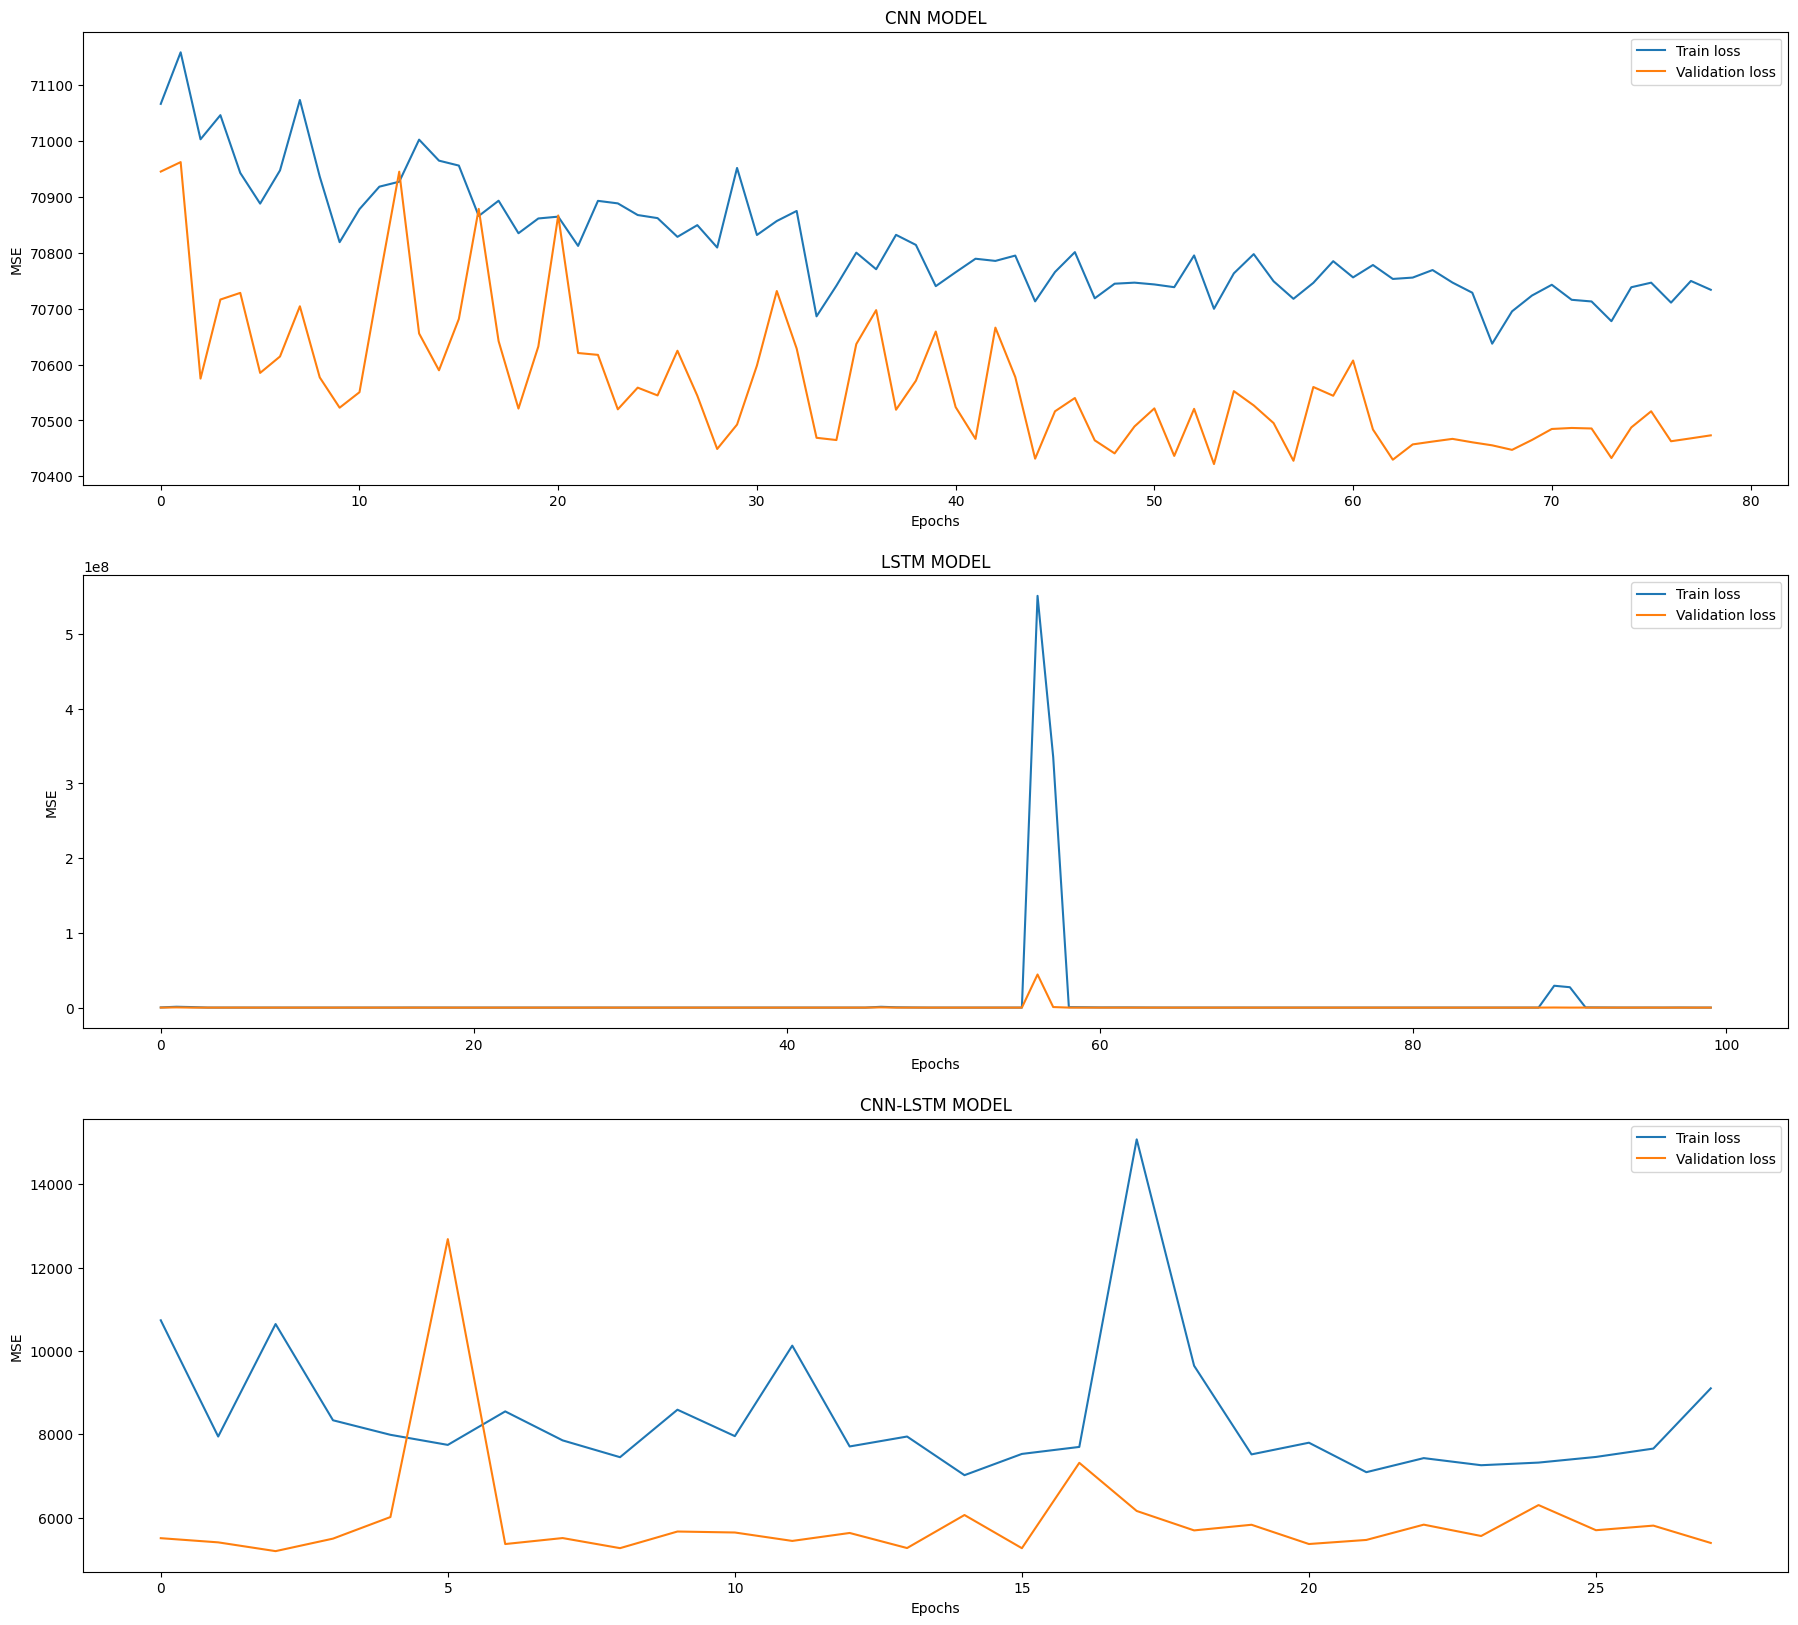

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, sharey=False,figsize=(22,20))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]


ax1.plot(cnn_history.history['loss'], label='Train loss')
ax1.plot(cnn_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('CNN MODEL')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(lstm_history.history['loss'], label='Train loss')
ax2.plot(lstm_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('LSTM MODEL')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax3.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('CNN-LSTM MODEL')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

plt.show()

#Evaluate RMSE

In [ ]:
import numpy as np

cnn_train_pred = cnn.predict(X_train_series)
cnn_valid_pred = cnn.predict(X_valid_series)
print('Train CNN rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation CNN rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

81/81 [==============================] - 0s 5ms/step
Train CNN rmse: 265.8980819421133
Validation CNN rmse: 265.46803873610565


In [ ]:
lstm_train_pred = lstm.predict(X_train_series)
lstm_valid_pred = lstm.predict(X_valid_series)
print('Train LSTM rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))


81/81 [==============================] - 2s 29ms/step
Train LSTM rmse: 107.96850121954465
Validation LSTM rmse: 97.9440193255695


In [ ]:
cnn_lstm_train_pred = cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = cnn_lstm.predict(X_valid_series_sub)
print('Train CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation CNN-LSTM rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

81/81 [==============================] - 0s 4ms/step
Train CNN-LSTM rmse: 84.06795903830475
Validation CNN-LSTM rmse: 73.41470866272492


#Conclusion:

 The CNN model exhibited a more fitting learning curve compared to the other two models, showing continued training loss up to a point of stability at different epochs. The validation loss decreased to a stable constant with a small gap relative to the training loss. Although scaling data before applying neural network models proved inefficient, different learning rates were explored, with values higher than 0.00001 resulting in poor learning curves.

On the CNN and CNN-LSTM algorithms, lower RMSE values were observed, but they performed differently based on learning curves. The generalization gap, where validation loss MSE is slightly lower than training loss MSE, suggests these models are effective in evaluating performance. The CNN-LSTM model's learning curve indicated that the validation loss did not learn the data as well as the other two models. Considering the RMSE of unseen data (validation data), the CNN model's learning curve demonstrated the best fit, making it the preferred algorithm.

In conclusion, this project showcases the practical application of diverse machine learning and deep learning techniques, with the CNN model emerging as the most effective algorithm for the given task.